Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [c]
>Slice: [m]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:07<00:00, 1056.95draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f832560c860>,
      dtype=object)

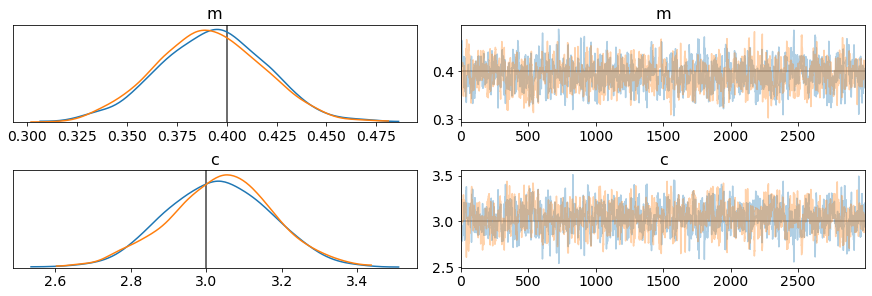

In [3]:
import pymc3 as pm
import numpy as np

import theano
import theano.tensor as tt
import matplotlib.pyplot as plt

# define a theano Op (Operator/Operation?) for our likelihood function
class LogLike(tt.Op):
    itypes = [tt.dvector] # expects vector of parameter values
    otypes = [tt.dscalar] # outputs a single scalar (loglik)
    
    def __init__(self, loglike, data, x, sigma):
        """
        Initialise the Op with various things that our log-likelihood
        function requires. below are the things that are needed in this 
        particular example.
        
        Parameters
        ----------
        loglike:
            The log-likelihood function we've defined
        data:
            The "observed" data that our log-likelihood functions takes in
        x:
            the independent variable that our models requires
        sigma:
            The noise standard deviation that our function requires
        """ 
        # inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma
    
    def perform(self, node, inputs, outputs):
        # method which is used when calling the Op
        theta = inputs
        
        # call log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)
        
        outputs[0][0] = np.array(logl)

def my_model(theta, x):
    m, c = theta[0]
    #c = theta[1]
    return m * x + c

def my_loglike(theta, x, data, sigma):
    """
    custom log likelihood function that takes in parameters
    
    Paramerters
    -----------
    theta : model parameters
    x : independent variable
    data : dependent variable
    sigma : should actually be in theta but is assumed to be fixed for now
    """ 
    model = my_model(theta, x) # assumed dgp given parameters theta (much like simulate funciton)
    
    return -(0.5 / sigma ** 2) * np.sum((data - model) ** 2)

N = 200
sigma = 1.
x = np.linspace(0., 9., N)

mtrue = .4
ctrue = 3.

truemodel = my_model([[mtrue, ctrue]], x)

data = sigma * np.random.randn(N) + truemodel

ndraws = 3000 # number of draws from the distribution 
nburn = 1000 # number of burn in points 

# create our Op
logl = LogLike(my_loglike, data, x, sigma)

# use PyMC3 to sample from log-likelihood
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)
    
    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable((m, c)) 
    
    # use DensityDist and lambda function 
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})
    
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

pm.traceplot(trace, lines=[('m', {}, [mtrue]), ('c', {}, [ctrue])] )